In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk, rectangle
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2

num_images = 10

class ImageDataset(Dataset):
    def __init__(self, _num_images, sizes, transform=None):     
        self.num_images = _num_images
        self.transform = transform
        self.images = []
        self.masks = []
        H, W = sizes
        for _ in range(num_images):    
            img = np.zeros((H, W), dtype=np.uint8)
            lbl_d = np.zeros((H, W), dtype=np.uint8)
            lbl_r = np.zeros((H, W), dtype=np.uint8)  
            radius = np.random.randint(20, 50)
            center = (np.random.randint(radius, W - radius), np.random.randint(radius, H - radius))
            rr, cc = disk(center, radius)
            img[rr, cc] = np.random.randint(0, 256)
            lbl_d[rr, cc] = 1
            start = (np.random.randint(0, W//2), np.random.randint(0, H//2))
            end = (np.random.randint(W//2, W), np.random.randint(H//2, H))
            rr, cc = rectangle(start, end)
            img[rr, cc] = np.random.randint(0, 256)
            lbl_r[rr, cc] = 1
            t_img = torch.tensor(img, dtype=torch.float)
            t_img = t_img.unsqueeze(0) # Добавления измерения количества изображений внутри одного изображения
            self.images.append(t_img)
            _mask = np.stack((lbl_d, lbl_r))
            t_msk = torch.tensor(_mask, dtype=torch.float)
            self.masks.append(t_msk)
    def __len__(self):
        return self.num_images
    def __getitem__(self, idx):
        img = self.images[idx] 
        lbl = self.masks[idx] 
        if self.transform:
            img = self.transform(img)
            lbl = self.transform(lbl)
        return img, lbl

def plot_img(data, mask):
    plt.imshow(data.squeeze())
    plt.imshow(mask[0], alpha=0.2)
    plt.imshow(mask[1], alpha=0.2)
    plt.show()

num_images = 8192
img_size = 64
batch_size = 32
dataset = ImageDataset(num_images, (256, 256), transform = v2.Compose([
    v2.Resize(size=img_size),
    v2.ToDtype(torch.float32, scale=False)
]))
train_length = int(len(dataset) * 0.8)
train_set, test_set = random_split(dataset, (train_length, len(dataset)-train_length))

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

for i, item in enumerate(trainloader):
    img, lbl = item
    print(img.shape, lbl.shape)
    if i == 3: break

torch.Size([32, 1, 64, 64]) torch.Size([32, 2, 64, 64])
torch.Size([32, 1, 64, 64]) torch.Size([32, 2, 64, 64])
torch.Size([32, 1, 64, 64]) torch.Size([32, 2, 64, 64])
torch.Size([32, 1, 64, 64]) torch.Size([32, 2, 64, 64])


In [4]:
import torch.nn as nn
import torch.nn.functional as F
# Изучить пороговые функции, например ReLu
# Изучить ООП, абстрактные классы

class Unet(nn.Module):
    def __init__(self, _num_channels=1, _num_classes=1):
        super().__init__()
        self.num_channel = _num_channels
        self.num_classes = _num_classes
        self.maxpool = nn.MaxPool2d(kernel_size = (2, 2))

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=self.num_channel, out_channels=16, kernel_size=(3, 3), padding='same')
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same')
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same')
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding='same')

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(2, 2), stride=(2, 2))
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding='same')
        self.upconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(2, 2), stride=(2, 2))
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding='same')
        self.upconv3 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(2, 2), stride=(2, 2))
        self.conv7 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding='same')
        self.conv8 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding='same')
        self.conv9 = nn.Conv2d(in_channels=16, out_channels=self.num_classes, kernel_size=(1, 1), padding='same')
        
        
    def forward(self, x):
        # x - (B, C, W, H)
        x = self.conv1(x)
        x1 = F.relu(x)
        
        x = self.maxpool(x1)
        x = self.conv2(x)
        x2 = F.relu(x)
        
        x = self.maxpool(x2)
        x = self.conv3(x)
        x3 = F.relu(x)

        x = self.maxpool(x3)
        x = self.conv4(x)

        x = self.upconv1(x)

        x = x3 + F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.upconv2(x)

        x = x2 + F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.upconv3(x)

        x = x1 + F.relu(x)

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        
        return F.sigmoid(x)

num_channel = 1
num_classes = 2
model = Unet(num_channel, num_classes)

device = torch.device('cuda:0')
model.to(device)

Unet(
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (upconv1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (upconv2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (upconv3): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv9): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1), padding=same)
)

In [5]:
from torch.optim import AdamW, lr_scheduler
from tqdm import tqdm

def dice_loss(src, dst, smooth = 1e-6):
    src = torch.flatten(src)
    dst = torch.flatten(dst)
    intersect = 2 * (src*dst).sum()
    return 1 - intersect/(src.sum() + dst.sum())

@torch.inference_mode()
def evaluate(model, test_loader, device):
    model.eval()
    val_score1 = 0
    val_score2 = 0
    for batch in test_loader:
        images, masks = batch # (B, C, H, W)
        images = images.to(device)
        masks = masks.to(device)
        masks_pred = model(images)
        val_score1 += dice_loss(masks_pred[:, 0, :, :], masks[:, 0, :, :])
        val_score2 += dice_loss(masks_pred[:, 1, :, :], masks[:, 1, :, :])
    model.train()
    return 1 - val_score1/len(test_loader), 1 - val_score2/len(test_loader)

def train(model, train_loader, test_loader, device, args):
    loss_func = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=args['LR'])
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma = args['lr_decay'])
    
    epochs = args['epochs']
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch}/{epochs}', unit='batch') as pbar:
            for batch in train_loader:
                images, masks = batch
                images = images.to(device)
                masks = masks.to(device)
                masks_pred = model(images)
    
                optimizer.zero_grad(set_to_none = True)
                
                loss = loss_func(F.softmax(masks_pred, dim=1), masks)
                loss +=dice_loss(masks_pred, masks)
    
                loss.backward()
                optimizer.step()
                
                pbar.update()
                epoch_loss += loss.item()
                pbar.set_postfix(**{'loss (batch)': loss.item()})
        scheduler.step()
        val_score1, val_score2 = evaluate(model, test_loader, device)
        print(f'Validate score: {val_score1:.3f},  {val_score2:.3f}, epoch_loss: {epoch_loss/len(train_loader):.3f}')

In [4]:
train_args = {
    'LR': 3e-4,
    'lr_decay': 0.99,
    'epochs': 10
}
train(model, trainloader, testloader, device, train_args)

Epoch 0/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 49.99batch/s, loss (batch)=0.816]


Validate score: 0.106,  0.559, epoch_loss: 0.821


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:03<00:00, 54.48batch/s, loss (batch)=0.79]


Validate score: 0.106,  0.562, epoch_loss: 0.813


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:03<00:00, 54.60batch/s, loss (batch)=0.801]


Validate score: 0.106,  0.570, epoch_loss: 0.809


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:03<00:00, 54.47batch/s, loss (batch)=0.802]


Validate score: 0.106,  0.569, epoch_loss: 0.805


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:03<00:00, 54.47batch/s, loss (batch)=0.798]


Validate score: 0.106,  0.570, epoch_loss: 0.805


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:03<00:00, 53.03batch/s, loss (batch)=0.815]


Validate score: 0.106,  0.570, epoch_loss: 0.805


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:03<00:00, 51.77batch/s, loss (batch)=0.802]


Validate score: 0.106,  0.571, epoch_loss: 0.804


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:03<00:00, 54.43batch/s, loss (batch)=0.797]


Validate score: 0.107,  0.571, epoch_loss: 0.804


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:03<00:00, 54.43batch/s, loss (batch)=0.791]


Validate score: 0.106,  0.573, epoch_loss: 0.804


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:03<00:00, 55.41batch/s, loss (batch)=0.797]


Validate score: 0.107,  0.572, epoch_loss: 0.804


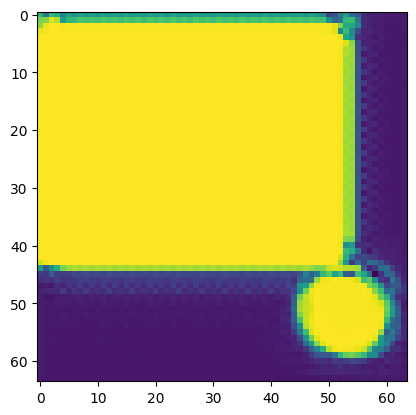

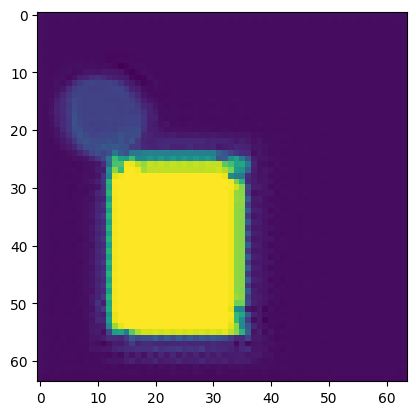

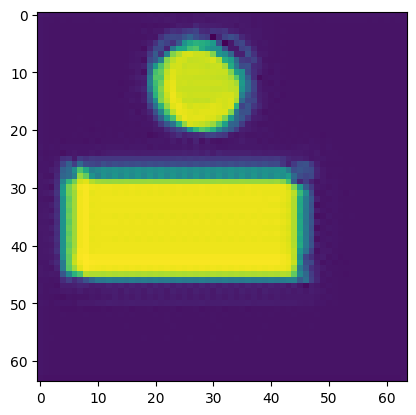

In [6]:
def plot_res(data):
    plt.imshow(data)
    plt.show()

for i, batch in enumerate(testloader):
    model.eval()
    img, lbl = batch
    img = img.to(device)
    res = model(img)
    res = res.detach().cpu().numpy()
    plot_res(res[0][0])
    if i == 2: break